In [1]:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import os

import tensorflow as tf
from tensorflow.python.platform import flags
import numpy as np
import keras
from keras import backend
import pandas as pd 


from cleverhans.attacks import DeepFool
from cleverhans.dataset import MNIST
from cleverhans.loss import CrossEntropy
from cleverhans.train import train
from cleverhans.utils import AccuracyReport
from cleverhans.utils_keras import cnn_model
from cleverhans.utils_keras import KerasModelWrapper
from cleverhans.utils_tf import model_eval
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

import glob
FLAGS = flags.FLAGS

NB_EPOCHS = 1
BATCH_SIZE = 32
LEARNING_RATE = .01
TRAIN_DIR = 'train_dir'
FILENAME = 'mnist.ckpt'
LOAD_MODEL = False



C:\Users\karth\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:

#################################################
# Loading the saved model
classifier = keras.models.load_model("64_new_cropped_model_15_epo.h5")
#classifier = keras.models.load_model("64_cnn_model1542233355.64.h5")

In [3]:
# Creating adverserial images 

def adverserial(train_start=0, train_end=60000, test_start=0,
                 test_end=10000, nb_epochs=NB_EPOCHS, batch_size=BATCH_SIZE,
                 learning_rate=LEARNING_RATE, train_dir=TRAIN_DIR,
                 filename=FILENAME, load_model=LOAD_MODEL,
                 testing=False, label_smoothing=0.1,eps=0.0005):
  """
  MNIST CleverHans tutorial
  :param train_start: index of first training set example
  :param train_end: index of last training set example
  :param test_start: index of first test set example
  :param test_end: index of last test set example
  :param nb_epochs: number of epochs to train model
  :param batch_size: size of training batches
  :param learning_rate: learning rate for training
  :param train_dir: Directory storing the saved model
  :param filename: Filename to save model under
  :param load_model: True for load, False for not load
  :param testing: if true, test error is calculated
  :param label_smoothing: float, amount of label smoothing for cross entropy
  :return: an AccuracyReport object
  """
  keras.layers.core.K.set_learning_phase(0)

  # Object used to keep track of (and return) key accuracies
  report = AccuracyReport()

  # Set TF random seed to improve reproducibility
  tf.set_random_seed(1234)

  if not hasattr(backend, "tf"):
    raise RuntimeError("This tutorial requires keras to be configured"
                       " to use the TensorFlow backend.")

  if keras.backend.image_dim_ordering() != 'tf':
    keras.backend.set_image_dim_ordering('tf')
    print("INFO: '~/.keras/keras.json' sets 'image_dim_ordering' to "
          "'th', temporarily setting to 'tf'")



  import numpy as np
  import cv2
  import glob
  import matplotlib.pyplot as plt
  # Change address
  addrs = glob.glob('clean_pic/*.jpg')
  image =[]
  for add in addrs:
      img = cv2.imread(add);
      img = cv2.resize(img, (64, 64), interpolation=cv2.INTER_CUBIC)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = img /255
      image.append(img)
    
  x_celeba = np.array(image)
  # Obtain Image Parameters

  #ADD RIGHT DATA 
  img_rows, img_cols, nchannels = x_celeba.shape[1:4]

  #MALE OR FEMALE 
  nb_classes = 1

  # Define input TF placeholder
  x = tf.placeholder(tf.float32, shape=(None, img_rows, img_cols,
                                        nchannels))
  y = tf.placeholder(tf.float32, shape=(None, nb_classes))


  keras_wrapped_model = KerasModelWrapper(classifier)

  # get session from the model
  sess =keras.backend.get_session()
    # create attack object
  #fgsm = FastGradientMethod(keras_wrapped_model, sess=sess)
  deepfool = DeepFool(keras_wrapped_model, sess=sess)

  #jsma_params = {'theta': 1., 'gamma': 0.1,
  #               'clip_min': 0., 'clip_max': 1.}
  deep_params = {'nb_candidate': 2, 'overshoot':0.02, 'max_iter':50, 'clip_min':0, 'clip_max':1}
  adv_x = deepfool.generate_np(x_celeba, **deep_params)
  # Consider the attack to be constant
  adv_x = tf.stop_gradient(adv_x) 
  a = adv_x.eval(session =sess)
  #plt.imshow(a[0])
  return(a)


In [4]:
# change the eps that suits our purpose
adv = adverserial(nb_epochs=1,
                 batch_size=32,
                 learning_rate=0.01,
                 train_dir="dir",
                 filename="file",
                 load_model=False,
                    eps=0.5)

[INFO 2018-11-27 10:10:35,734 cleverhans] Constructing new graph for attack DeepFool
[INFO 2018-11-27 10:10:43,427 cleverhans] Attack result at iteration 5 is [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0]
[INFO 2018-11-27 10:10:44,934 cleverhans] Attack result at iteration 6 is [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[INFO 2018-11-27 10:10:44,934 cleverhans] 50 out of 50 become adversarial examples at iteration 6


In [5]:
adv.shape

(50, 64, 64, 3)

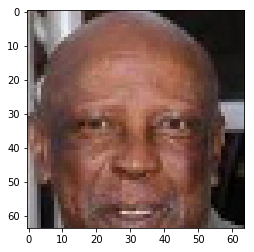

In [14]:
# print one adverserial image
plt.imshow(adv[10])

In [7]:
# predict classes on 0.5 probability threshold
adv_pred = classifier.predict_classes(adv)
adv_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int64)

In [8]:
# getting the probabilities for comparison
adv_prob= classifier.predict_proba(adv)
#adv_prob

In [40]:
# creating labels for acccuracy score
y = np.zeros(50)

In [9]:
#Run only For Male dataset 
#Creating labels for accuracy score

y = np.ones(50)

In [10]:
# accuracy score
accuracy_score(y, adv_pred)

0.0

In [11]:
# reading placeholders for saving the adverserial images. Copy the clean images to start off so that images have the same file names
addrs = glob.glob('adv_pic/*.jpg')

In [12]:
#Save adverserial images  
for i, a in enumerate(adv):
    plt.imsave(addrs[i],a)

In [13]:
# saving the probailities - change the file name accordingly
pd.DataFrame(adv_prob).to_csv("DeepFool_adv_prob_Males.csv")

# for clean images of adverserial prediction only

In [25]:
# load Clean Images
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
#kernel = np.ones((2,2),np.float32)/4
# Change address accordingly
addrs = glob.glob('Physical_07/*.jpg')
image =[]
for add in addrs:
  img = cv2.imread(add);
  img = cv2.resize(img, (64, 64), interpolation=cv2.INTER_CUBIC)
 # img = cv2.filter2D(img,-1,kernel)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = img /255
  image.append(img)

clean_img = np.array(image)

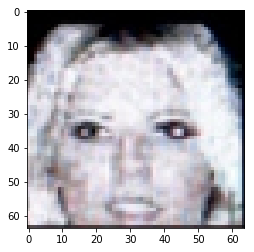

In [169]:
plt.imshow(clean_img[1])

In [170]:
clean_pred = classifier.predict_classes(clean_img)
clean_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1])

In [171]:
# creating labels for acccuracy score
y = np.zeros(50)
y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [172]:
accuracy_score(y, clean_pred)

0.14

In [173]:
clean_prob = classifier.predict_proba(clean_img)

In [174]:
clean_prob

array([[3.39064598e-02, 9.66093600e-01],
       [4.62543488e-01, 5.37456572e-01],
       [8.84102881e-02, 9.11589682e-01],
       [8.60243011e-03, 9.91397500e-01],
       [1.71518289e-02, 9.82848167e-01],
       [1.57492876e-01, 8.42507184e-01],
       [3.28679293e-01, 6.71320677e-01],
       [3.10105890e-01, 6.89894021e-01],
       [4.14868584e-09, 1.00000000e+00],
       [5.25012612e-01, 4.74987388e-01],
       [2.69178837e-03, 9.97308254e-01],
       [3.11896583e-04, 9.99688148e-01],
       [2.91889340e-01, 7.08110631e-01],
       [4.41452891e-01, 5.58547139e-01],
       [1.08304627e-01, 8.91695380e-01],
       [6.45275190e-02, 9.35472488e-01],
       [6.61205113e-01, 3.38794887e-01],
       [1.81036368e-01, 8.18963587e-01],
       [5.15183322e-02, 9.48481679e-01],
       [1.42879888e-01, 8.57120097e-01],
       [1.32690603e-02, 9.86730933e-01],
       [6.42212093e-01, 3.57787877e-01],
       [6.86797947e-02, 9.31320250e-01],
       [1.07071188e-04, 9.99892950e-01],
       [1.308715

In [175]:
pd.DataFrame(clean_prob).to_csv("Phase7_physical_prob.csv")

In [240]:
# class predictions --- 0 = Female , 1 = Male 
pred = classifier.predict_classes(adv)
pred

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0])

In [241]:
# Predict probabilities 
adv_prob = classifier.predict_proba(adv)